# Import

In [54]:
import pandas
from sklearn.ensemble import GradientBoostingClassifier
import evaluation

# Read training data

In [55]:
folder = 'C:/MSDS/Proj/flav/'
train = pandas.read_csv(folder + 'training.csv', index_col='id')

In [56]:
train.head()

,LifeTime,dira,FlightDistance,FlightDistanceError,IP,IPSig,VertexChi2,pt,DOCAone,DOCAtwo,...,p1_p,p2_p,p0_eta,p1_eta,p2_eta,SPDhits,production,signal,mass,min_ANNmuon
id,,,,,,,,,,,,,,,,,,,,,
18453471,0.001578,0.999999,14.033335,0.681401,0.016039,0.451886,1.900433,1482.037476,0.066667,0.060602,...,12290.760742,39264.398438,3.076006,4.003800,4.031514,458,-99,0,1866.300049,0.277559
5364094,0.000988,0.999705,5.536157,0.302341,0.142163,9.564503,0.865666,3050.720703,0.024022,0.019245,...,16562.667969,7341.257812,3.228553,2.786543,2.975564,406,-99,0,1727.095947,0.225924
11130990,0.000877,0.999984,6.117302,0.276463,0.034746,1.970751,10.975849,3895.908691,0.055044,0.047947,...,22695.388672,10225.309570,3.536903,2.865686,3.052810,196,-99,0,1898.588013,0.368630
15173787,0.000854,0.999903,5.228067,0.220739,0.076389,4.271331,3.276358,4010.781738,0.053779,0.006417,...,16909.515625,9141.426758,3.087461,3.218034,2.375592,137,-99,0,1840.410034,0.246045
1102544,0.001129,0.999995,39.069534,1.898197,0.120936,4.984982,0.468348,4144.546875,0.004491,0.037326,...,97612.804688,47118.785156,4.632295,4.711155,4.296878,477,-99,0,1899.793945,0.222060


# Define training features
Here we use subset of the all features to pass the agreement checking

In [57]:
variables = ['LifeTime',
             'FlightDistance',
             'pt',
             'dira',
             'VertexChi2',
             'IP'
             ]

# Baseline training

In [58]:
baseline = GradientBoostingClassifier(n_estimators=80, learning_rate=0.1, subsample=0.4,
                                      min_samples_leaf=10, max_depth=6, random_state=11)
baseline.fit(train[variables], train['signal'])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=10,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=80, presort='auto', random_state=11,
              subsample=0.4, verbose=0, warm_start=False)

# Check agreement test

In [59]:
check_agreement = pandas.read_csv(folder + 'check_agreement.csv', index_col='id')
agreement_probs = baseline.predict_proba(check_agreement[variables])[:, 1]

ks = evaluation.compute_ks(
    agreement_probs[check_agreement['signal'].values == 0],
    agreement_probs[check_agreement['signal'].values == 1],
    check_agreement[check_agreement['signal'] == 0]['weight'].values,
    check_agreement[check_agreement['signal'] == 1]['weight'].values)
print('KS metric', ks, ks < 0.09)


KS metric 0.0541694136317 True


# Check correlation test

In [60]:
check_correlation = pandas.read_csv(folder + 'check_correlation.csv', index_col='id')
correlation_probs = baseline.predict_proba(check_correlation[variables])[:, 1]
cvm = evaluation.compute_cvm(correlation_probs, check_correlation['mass'])
print ('CvM metric', cvm, cvm < 0.002)

CvM metric 0.0010836993545 True


# Compute weighted AUC on the training data with min_ANNmuon > 0.4

In [61]:
train_eval = train[train['min_ANNmuon'] > 0.4]
train_probs = baseline.predict_proba(train_eval[variables])[:, 1]
roc_auc = evaluation.roc_auc_truncated(train_eval['signal'], train_probs)
print( 'AUC', roc_auc)

AUC 0.973532314719


In [62]:
import numpy as np
print(train_probs)

confm_probs = np.round(train_probs, decimals=0)
print(confm_probs)

from sklearn.metrics import confusion_matrix
confusion_matrix(train_eval['signal'], confm_probs)

[ 0.1554039   0.63944509  0.66856668 ...,  0.91320171  0.92641089
  0.88107234]
[ 0.  1.  1. ...,  1.  1.  1.]


array([[ 5927,  1872],
       [ 3494, 26719]])

In [63]:
from pandas_ml import ConfusionMatrix
confusion_matrix = ConfusionMatrix(train_eval['signal'], confm_probs)
print("Confusion matrix:\n%s" % confusion_matrix)

Confusion matrix:
Predicted  False  True  __all__
Actual                         
False          2    12       14
True          21    47       68
__all__       23    59       82


In [64]:
print(confusion_matrix.TP)

47


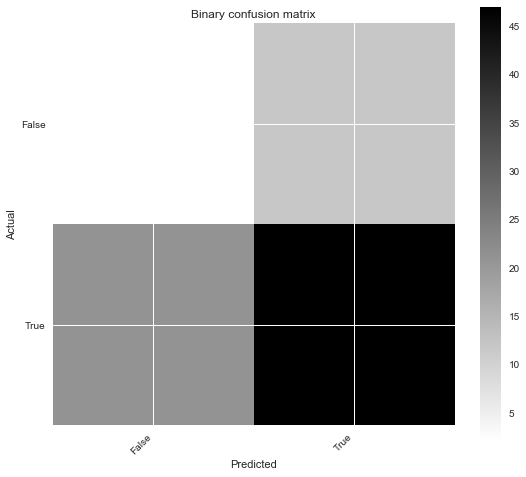

In [65]:
%matplotlib inline
import matplotlib.pyplot as plt

confusion_matrix.plot()
plt.show()

In [66]:
confusion_matrix.print_stats()

population: 82
P: 68
N: 14
PositiveTest: 59
NegativeTest: 23
TP: 47
TN: 2
FP: 12
FN: 21
TPR: 0.691176470588
TNR: 0.142857142857
PPV: 0.796610169492
NPV: 0.0869565217391
FPR: 0.857142857143
FDR: 0.203389830508
FNR: 0.308823529412
ACC: 0.59756097561
F1_score: 0.740157480315
MCC: -0.139010846811
informedness: -0.165966386555
markedness: -0.116433308769
prevalence: 0.829268292683
LRP: 0.80637254902
LRN: 2.16176470588
DOR: 0.373015873016
FOR: 0.913043478261


# Predict test, create file for kaggle

In [67]:
test = pandas.read_csv(folder + 'test.csv', index_col='id')
result = pandas.DataFrame({'id': test.index})
result['prediction'] = baseline.predict_proba(test[variables])[:, 1]

In [68]:
result.to_csv('baseline.csv', index=False, sep=',')

In [69]:
ls -l baseline.csv

 Volume in drive C is Windows
 Volume Serial Number is 1C17-4C29

 Directory of C:\MSDS\Proj\flavours-of-physics-start-master


 Directory of C:\MSDS\Proj\flavours-of-physics-start-master

10/01/2018  08:36 PM        24,747,390 baseline.csv
               1 File(s)     24,747,390 bytes
               0 Dir(s)  83,198,574,592 bytes free


In [70]:
result.to_csv?

In [71]:
?ls